In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')


ModuleNotFoundError: No module named 'lsst.daf'

In [2]:
def estimate_purity_completness(df_obj, tru_obj, match_value = 1):
    """Estimate the purity and completness of the detected objects
    
        Parameters
    ----------
    obj4_field : `pd.dataframe`
        Detected objects
    tru_obj : `pd.dataframe`
        True variable objects
    match_value : `float`
        matching radius in arcsec    
    
    Returns
    -------
    purity, completeness  : `float`, `float`
        Purity and completness
    """

    # all of the diaObjects in a field
    dia_obj_SC = SkyCoord(ra=df_obj['ra'].values*u.degree, dec=df_obj['dec'].values*u.degree) 
    # all of the variable objects in a field
    tru_obj_SC = SkyCoord(ra=tru_obj['ra'].values*u.degree, dec=tru_obj['dec'].values*u.degree)
    # match the observations to the truth
    idx, d2d, d3d = tru_obj_SC.match_to_catalog_sky(dia_obj_SC)
    # index of all diaObj that are within match_value of a true variable object
    idx_close = idx[d2d.to(u.arcsec).value<match_value]

    # all of diaObjects thare are within match_value of a variable object
    matches_close = df_obj.iloc[idx_close]

    # fraction of dia Objects that are actually near a variable objects 
    purity = len(matches_close)/len(df_obj)

    # fraction of variable objects that have been detected 
    completnes = len(matches_close)/len(tru_obj_SC)

    return purity, completnes

In [3]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value


In [4]:
repo = 'embargo_or4'

instrument = 'LSSTComCamSim'
schema =  f'pp_ppdb_lsstcomcamsim_or4'

butler = dafButler.Butler(repo, instrument=instrument)
registry = butler.registry
# skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini
ERROR:lsst.daf.butler.direct_butler._direct_butler:Failed to instantiate Butler from config s3://embargo@rubin-summit-users/butler.yaml.


OperationalError: (psycopg2.OperationalError) connection to server at "172.24.5.60", port 5432 failed: FATAL:  no such user
connection to server at "172.24.5.60", port 5432 failed: FATAL:  no such user

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [6]:
# This is to see all of the columns avaliable
with apdbQuery.connection as connection:
    # Query to fetch all column names from the DiaObject table
    query_columns = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'pp_ppdb_lsstcomcamsim_or4' AND table_name = 'DiaObject';
    '''
    df_columns = pd.read_sql_query(query_columns, connection)
    print("Available columns:", df_columns['column_name'].tolist())

Available columns: ['diaObjectId', 'validityStart', 'validityEnd', 'ra', 'raErr', 'dec', 'decErr', 'ra_dec_Cov', 'radecMjdTai', 'pmRa', 'pmRaErr', 'pmDec', 'pmDecErr', 'parallax', 'parallaxErr', 'pmRa_pmDec_Cov', 'pmRa_parallax_Cov', 'pmDec_parallax_Cov', 'pmParallaxLnL', 'pmParallaxChi2', 'pmParallaxNdata', 'u_psfFluxMean', 'u_psfFluxMeanErr', 'u_psfFluxSigma', 'u_psfFluxChi2', 'u_psfFluxNdata', 'u_fpFluxMean', 'u_fpFluxMeanErr', 'u_fpFluxSigma', 'g_psfFluxMean', 'g_psfFluxMeanErr', 'g_psfFluxSigma', 'g_psfFluxChi2', 'g_psfFluxNdata', 'g_fpFluxMean', 'g_fpFluxMeanErr', 'g_fpFluxSigma', 'r_psfFluxMean', 'r_psfFluxMeanErr', 'r_psfFluxSigma', 'r_psfFluxChi2', 'r_psfFluxNdata', 'r_fpFluxMean', 'r_fpFluxMeanErr', 'r_fpFluxSigma', 'i_psfFluxMean', 'i_psfFluxMeanErr', 'i_psfFluxSigma', 'i_psfFluxChi2', 'i_psfFluxNdata', 'i_fpFluxMean', 'i_fpFluxMeanErr', 'i_fpFluxSigma', 'z_psfFluxMean', 'z_psfFluxMeanErr', 'z_psfFluxSigma', 'z_psfFluxChi2', 'z_psfFluxNdata', 'z_fpFluxMean', 'z_fpFluxMeanErr

In [7]:
# This is to see all of the columns avaliable
with apdbQuery.connection as connection:
    # Query to fetch all column names from the Source table
    query_columns = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'pp_ppdb_lsstcomcamsim_or4' AND table_name = 'DiaSource';
    '''
    df_columns = pd.read_sql_query(query_columns, connection)
    print("Available columns:", df_columns['column_name'].tolist())
    
list_of_diaSource_columns = df_columns['column_name'].tolist()

list_of_flags = [s for s in list_of_diaSource_columns if 'flag' in s or 'Flag' in s]
list_of_flags

Available columns: ['diaSourceId', 'visit', 'detector', 'diaObjectId', 'ssObjectId', 'parentDiaSourceId', 'ssObjectReassocTime', 'midpointMjdTai', 'ra', 'raErr', 'dec', 'decErr', 'ra_dec_Cov', 'x', 'xErr', 'y', 'yErr', 'x_y_Cov', 'centroid_flag', 'apFlux', 'apFluxErr', 'apFlux_flag', 'apFlux_flag_apertureTruncated', 'snr', 'psfFlux', 'psfFluxErr', 'psfRa', 'psfRaErr', 'psfDec', 'psfDecErr', 'psfFlux_psfRa_Cov', 'psfFlux_psfDec_Cov', 'psfRa_psfDec_Cov', 'psfLnL', 'psfChi2', 'psfNdata', 'psfFlux_flag', 'psfFlux_flag_edge', 'psfFlux_flag_noGoodPixels', 'trailFlux', 'trailFluxErr', 'trailRa', 'trailRaErr', 'trailDec', 'trailDecErr', 'trailLength', 'trailLengthErr', 'trailAngle', 'trailAngleErr', 'trailFlux_trailRa_Cov', 'trailFlux_trailDec_Cov', 'trailFlux_trailLength_Cov', 'trailFlux_trailAngle_Cov', 'trailRa_trailDec_Cov', 'trailRa_trailLength_Cov', 'trailRa_trailAngle_Cov', 'trailDec_trailLength_Cov', 'trailDec_trailAngle_Cov', 'trailLength_trailAngle_Cov', 'trailLnL', 'trailChi2', 'tra

['centroid_flag',
 'apFlux_flag',
 'apFlux_flag_apertureTruncated',
 'psfFlux_flag',
 'psfFlux_flag_edge',
 'psfFlux_flag_noGoodPixels',
 'trail_flag_edge',
 'forced_PsfFlux_flag',
 'forced_PsfFlux_flag_edge',
 'forced_PsfFlux_flag_noGoodPixels',
 'shape_flag',
 'shape_flag_no_pixels',
 'shape_flag_not_contained',
 'shape_flag_parent_source',
 'pixelFlags',
 'pixelFlags_bad',
 'pixelFlags_cr',
 'pixelFlags_crCenter',
 'pixelFlags_edge',
 'pixelFlags_interpolated',
 'pixelFlags_interpolatedCenter',
 'pixelFlags_offimage',
 'pixelFlags_saturated',
 'pixelFlags_saturatedCenter',
 'pixelFlags_suspect',
 'pixelFlags_suspectCenter',
 'pixelFlags_streak',
 'pixelFlags_streakCenter',
 'pixelFlags_injected',
 'pixelFlags_injectedCenter',
 'pixelFlags_injected_template',
 'pixelFlags_injected_templateCenter']

In [8]:
# This is to see all of the columns avaliable
with apdbQuery.connection as connection:
    # Query to fetch all column names from the DiaObject table
    query_columns = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'pp_ppdb_lsstcomcamsim_or4' AND table_name = 'DiaForcedSource';
    '''
    df_columns = pd.read_sql_query(query_columns, connection)
    print("Available columns:", df_columns['column_name'].tolist())
    
list_of_diaForcedSource_columns = df_columns['column_name'].tolist()

Available columns: ['diaForcedSourceId', 'diaObjectId', 'ra', 'dec', 'visit', 'detector', 'psfFlux', 'psfFluxErr', 'midpointMjdTai', 'scienceFlux', 'scienceFluxErr', 'band', 'time_processed', 'time_withdrawn']


In [9]:
# This is to see all of the columns avaliable
with apdbQuery.connection as connection:
    # Query to fetch all column names from the DiaObject table
    query_columns = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'pp_ppdb_lsstcomcamsim_or4' AND table_name = 'DiaSource';
    '''
    df_columns = pd.read_sql_query(query_columns, connection)
    print("Available columns:", df_columns['column_name'].tolist())
    
list_of_diaSource_columns = df_columns['column_name'].tolist()

list_of_flags = [s for s in list_of_diaSource_columns if 'flag' in s or 'Flag' in s]
list_of_flags

Available columns: ['diaSourceId', 'visit', 'detector', 'diaObjectId', 'ssObjectId', 'parentDiaSourceId', 'ssObjectReassocTime', 'midpointMjdTai', 'ra', 'raErr', 'dec', 'decErr', 'ra_dec_Cov', 'x', 'xErr', 'y', 'yErr', 'x_y_Cov', 'centroid_flag', 'apFlux', 'apFluxErr', 'apFlux_flag', 'apFlux_flag_apertureTruncated', 'snr', 'psfFlux', 'psfFluxErr', 'psfRa', 'psfRaErr', 'psfDec', 'psfDecErr', 'psfFlux_psfRa_Cov', 'psfFlux_psfDec_Cov', 'psfRa_psfDec_Cov', 'psfLnL', 'psfChi2', 'psfNdata', 'psfFlux_flag', 'psfFlux_flag_edge', 'psfFlux_flag_noGoodPixels', 'trailFlux', 'trailFluxErr', 'trailRa', 'trailRaErr', 'trailDec', 'trailDecErr', 'trailLength', 'trailLengthErr', 'trailAngle', 'trailAngleErr', 'trailFlux_trailRa_Cov', 'trailFlux_trailDec_Cov', 'trailFlux_trailLength_Cov', 'trailFlux_trailAngle_Cov', 'trailRa_trailDec_Cov', 'trailRa_trailLength_Cov', 'trailRa_trailAngle_Cov', 'trailDec_trailLength_Cov', 'trailDec_trailAngle_Cov', 'trailLength_trailAngle_Cov', 'trailLnL', 'trailChi2', 'tra

['centroid_flag',
 'apFlux_flag',
 'apFlux_flag_apertureTruncated',
 'psfFlux_flag',
 'psfFlux_flag_edge',
 'psfFlux_flag_noGoodPixels',
 'trail_flag_edge',
 'forced_PsfFlux_flag',
 'forced_PsfFlux_flag_edge',
 'forced_PsfFlux_flag_noGoodPixels',
 'shape_flag',
 'shape_flag_no_pixels',
 'shape_flag_not_contained',
 'shape_flag_parent_source',
 'pixelFlags',
 'pixelFlags_bad',
 'pixelFlags_cr',
 'pixelFlags_crCenter',
 'pixelFlags_edge',
 'pixelFlags_interpolated',
 'pixelFlags_interpolatedCenter',
 'pixelFlags_offimage',
 'pixelFlags_saturated',
 'pixelFlags_saturatedCenter',
 'pixelFlags_suspect',
 'pixelFlags_suspectCenter',
 'pixelFlags_streak',
 'pixelFlags_streakCenter',
 'pixelFlags_injected',
 'pixelFlags_injectedCenter',
 'pixelFlags_injected_template',
 'pixelFlags_injected_templateCenter']

In [10]:
#latest = False does not work
or4_obj = apdbQuery.load_objects(limit=1e7, latest=True)

# We got all of them, less than 1e7 here
assert len(or4_obj) < 1e7

In [11]:
len(or4_obj)

1429486

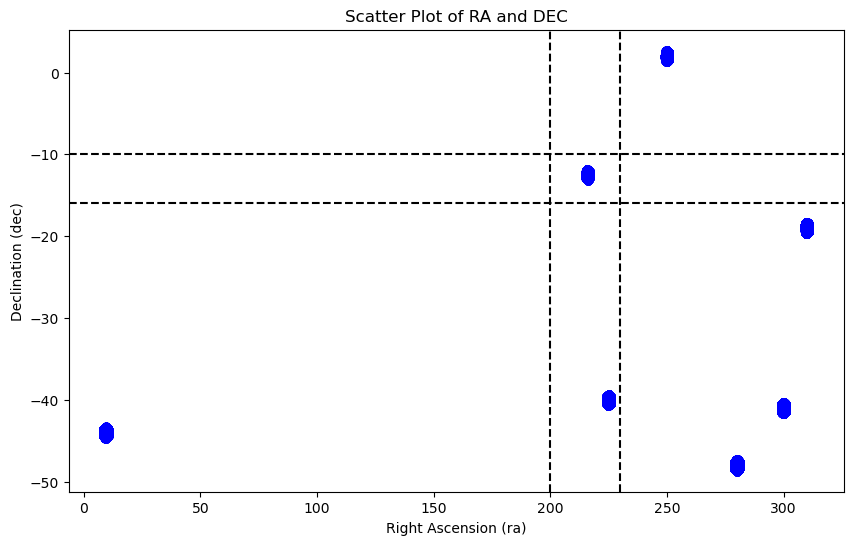

In [12]:
# Extract the columns 'ra' and 'dec'
ra = or4_obj['ra']
dec = or4_obj['dec']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ra, dec, c='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Right Ascension (ra)')
plt.ylabel('Declination (dec)')
plt.title('Scatter Plot of RA and DEC')

plt.axhline(y=-10, color='k', ls = '--')
plt.axhline(y=-16, color='k', ls = '--')
plt.axvline(x=200, color='k', ls = '--')
plt.axvline(x=230, color='k', ls = '--')

# Show the plot
plt.show()

In [13]:
# lets look at only one field
# objects
obj4_field = or4_obj[(or4_obj['ra'] > 200) & (or4_obj['ra'] < 230) & (or4_obj['dec'] > -16) & (or4_obj['dec'] < -10)]
obj4_field



,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxPercentile95,y_psfFluxMin,y_psfFluxMax,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources
153062,3068394109505896449,2024-06-26 02:12:25+00:00,None,215.940635,1.164427e-05,-12.980294,1.620619e-05,4.259947e-11,60487.089310,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
153063,3068394109505896450,2024-06-26 02:49:53+00:00,None,215.932781,NaN,-12.977373,NaN,NaN,60487.115497,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:48:25+00:00,6
153064,3068394109505896451,2024-06-26 02:49:53+00:00,None,215.955608,NaN,-12.984331,NaN,NaN,60487.115497,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:26:58+00:00,3
153065,3068394109505896452,2024-06-26 02:32:51+00:00,None,216.003270,9.587428e-07,-12.998648,9.911652e-07,3.736781e-15,60487.103777,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:26:58+00:00,3
153066,3068394109505896453,2024-06-26 02:12:25+00:00,None,215.952055,1.678011e-05,-12.981463,1.948738e-05,2.935007e-11,60487.089310,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171479,3068394172890218585,2024-06-26 02:55:53+00:00,None,215.677023,2.335178e-05,-12.260069,2.930849e-05,-1.390424e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171480,3068394172890218592,2024-06-26 02:55:53+00:00,None,215.558428,NaN,-12.258833,NaN,NaN,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171481,3068394172890218629,2024-06-26 02:55:53+00:00,None,215.749328,NaN,-12.203916,NaN,NaN,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171482,3068394172890218631,2024-06-26 02:55:53+00:00,None,215.565520,3.946260e-05,-12.211074,4.004168e-05,-9.789058e-13,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1


In [14]:
ra_min = obj4_field['ra'].min()-0.01
ra_max = obj4_field['ra'].max()+0.01
dec_min = obj4_field['dec'].min()-0.01
dec_max = obj4_field['dec'].max()+0.01

ra_min_in_rad = (ra_min*u.deg).to(u.rad).value
ra_max_in_rad = (ra_max*u.deg).to(u.rad).value
dec_min_in_rad = (dec_min*u.deg).to(u.rad).value
dec_max_in_rad = (dec_max*u.deg).to(u.rad).value

In [15]:
ra_max_in_rad

3.781319023336886

In [16]:
ra_max

216.653621029734

In [17]:
with apdbQuery.connection as connection:
    src4_field = pd.read_sql_query(f'''
        SELECT 
            "diaSourceId", 
            "diaObjectId", 
            "ra", 
            "dec", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "snr", 
            "band", 
            "time_processed", 
            "time_withdrawn",
            "centroid_flag",
            "apFlux_flag",
            "apFlux_flag_apertureTruncated",
            "psfFlux_flag",
            "psfFlux_flag_edge",
            "psfFlux_flag_noGoodPixels",
            "trail_flag_edge",
            "forced_PsfFlux_flag",
            "forced_PsfFlux_flag_edge",
            "forced_PsfFlux_flag_noGoodPixels",
            "shape_flag",
            "shape_flag_no_pixels",
            "shape_flag_not_contained",
            "shape_flag_parent_source",
            "pixelFlags",
            "pixelFlags_bad",
            "pixelFlags_cr",
            "pixelFlags_crCenter",
            "pixelFlags_edge",
            "pixelFlags_interpolated",
            "pixelFlags_interpolatedCenter",
            "pixelFlags_offimage",
            "pixelFlags_saturated",
            "pixelFlags_saturatedCenter",
            "pixelFlags_suspect",
            "pixelFlags_suspectCenter",
            "pixelFlags_streak",
            "pixelFlags_streakCenter",
            "pixelFlags_injected",
            "pixelFlags_injectedCenter",
            "pixelFlags_injected_template",
            "pixelFlags_injected_templateCenter",
            "reliability"
        FROM "{schema}"."DiaSource"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        LIMIT 3000000;
    ''', connection)

In [18]:
with apdbQuery.connection as connection:
    srcForced4_field = pd.read_sql_query(f'''
        SELECT 
            "diaForcedSourceId", 
            "diaObjectId", 
            "ra", 
            "dec",
            "visit",
            "detector", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "band"
        FROM "{schema}"."DiaForcedSource"
        WHERE "ra" BETWEEN {ra_min_in_rad} AND {ra_max_in_rad}
        AND "dec" BETWEEN {dec_min_in_rad} AND {dec_max_in_rad}
        LIMIT 3000000;
    ''', connection)
    
srcForced4_field['ra'] = radians_to_degrees(srcForced4_field['ra'].values)
srcForced4_field['dec'] = radians_to_degrees(srcForced4_field['dec'].values)

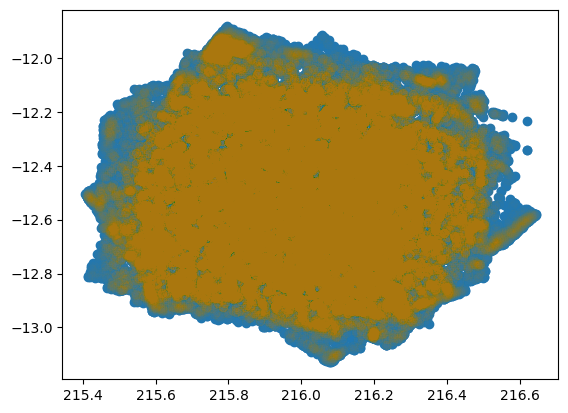

In [19]:
plt.scatter(src4_field['ra'],src4_field['dec'])
plt.scatter(srcForced4_field['ra'],srcForced4_field['dec'], alpha=0.01)

In [20]:
srcForced4_field

,diaForcedSourceId,diaObjectId,ra,dec,visit,detector,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,band
0,3068394135305060511,3068394128850026651,215.958734,-12.388451,7024062500214,7,60487.101903,-69.555214,191.184509,14.047091,182.307693,g
1,3068394126702543173,3068394124559253552,215.802857,-12.384766,7024062500206,4,60487.096808,-245.488205,306.655579,85989.218750,299.880341,i
2,3068394127776284999,3068394124559253552,215.802857,-12.384766,7024062500207,4,60487.097273,-1532.248169,294.981079,78296.476562,287.435394,i
3,3068394128850026875,3068394124559253552,215.802857,-12.384766,7024062500208,4,60487.097739,-1213.916748,296.202148,78951.953125,289.547272,i
4,3068394129936351591,3068394124559253552,215.802857,-12.384766,7024062500209,7,60487.098207,-1469.696777,312.936584,82984.968750,304.652283,i
...,...,...,...,...,...,...,...,...,...,...,...,...
264952,3068394152476541174,3068394128862609414,215.999303,-12.350839,7024062500230,5,60487.110742,-219.865646,250.093033,11007.870117,243.386871,r
264953,3068394154636607722,3068394128862609414,215.999303,-12.350839,7024062500232,8,60487.111744,433.172913,264.657501,11763.208984,258.094452,r
264954,3068394155693572237,3068394128862609414,215.999303,-12.350839,7024062500233,4,60487.112214,369.258575,244.273987,11573.331055,237.726303,r
264955,3068394157841055913,3068394128862609414,215.999303,-12.350839,7024062500235,4,60487.113154,-40.438812,229.056122,11045.669922,222.245682,r


In [21]:
print(len(srcForced4_field))
print(len(src4_field))


264957
75818


In [22]:
i1 = 7436
i2 = 7565
# why this sometimes takes so long 
# find which ones are variable
df_single_ps1 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i1)+'.parquet')
df_single_ps2 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps = pd.concat([df_single_ps1, df_single_ps2], ignore_index=True)

df_single_ps1_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i1)+'.parquet')
df_single_ps2_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps_flux = pd.concat([df_single_ps1_flux, df_single_ps2_flux], ignore_index=True)

#df_single_sso = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/sso_'+str(i)+'.parquet')
#df_single_gal = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_'+str(i)+'.parquet')
df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]


ra_min =215.60
ra_max = 216.40
dec_min = -12.90
dec_max = -12.15

# Apply the filter to the dataframe
tru_var_obj = df_single_ps_var[
    (df_single_ps_var['ra'] >= ra_min) & (df_single_ps_var['ra'] <= ra_max) &
    (df_single_ps_var['dec'] >= dec_min) & (df_single_ps_var['dec'] <= dec_max)]

obj4_field  = obj4_field[
    (obj4_field['ra'] >= ra_min) & (obj4_field['ra'] <= ra_max) &
    (obj4_field['dec'] >= dec_min) & (obj4_field['dec'] <= dec_max)]


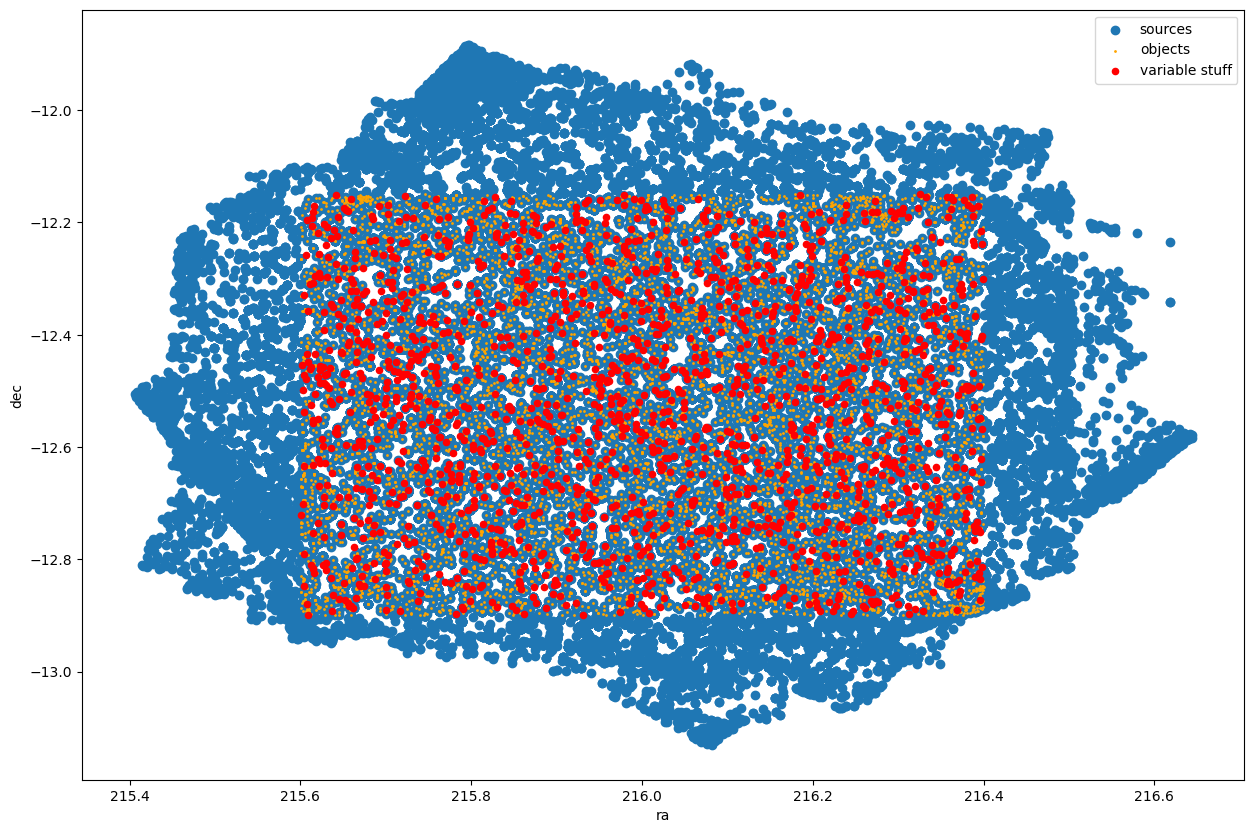

In [23]:
plt.figure(figsize=(15,10))

plt.scatter(src4_field['ra'],src4_field['dec'], label = 'sources')
plt.scatter(obj4_field['ra'],obj4_field['dec'], s=1, color = 'orange', label = 'objects')
plt.scatter(tru_var_obj['ra'],tru_var_obj['dec'], color = 'red', label = 'variable stuff', s=20)
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()

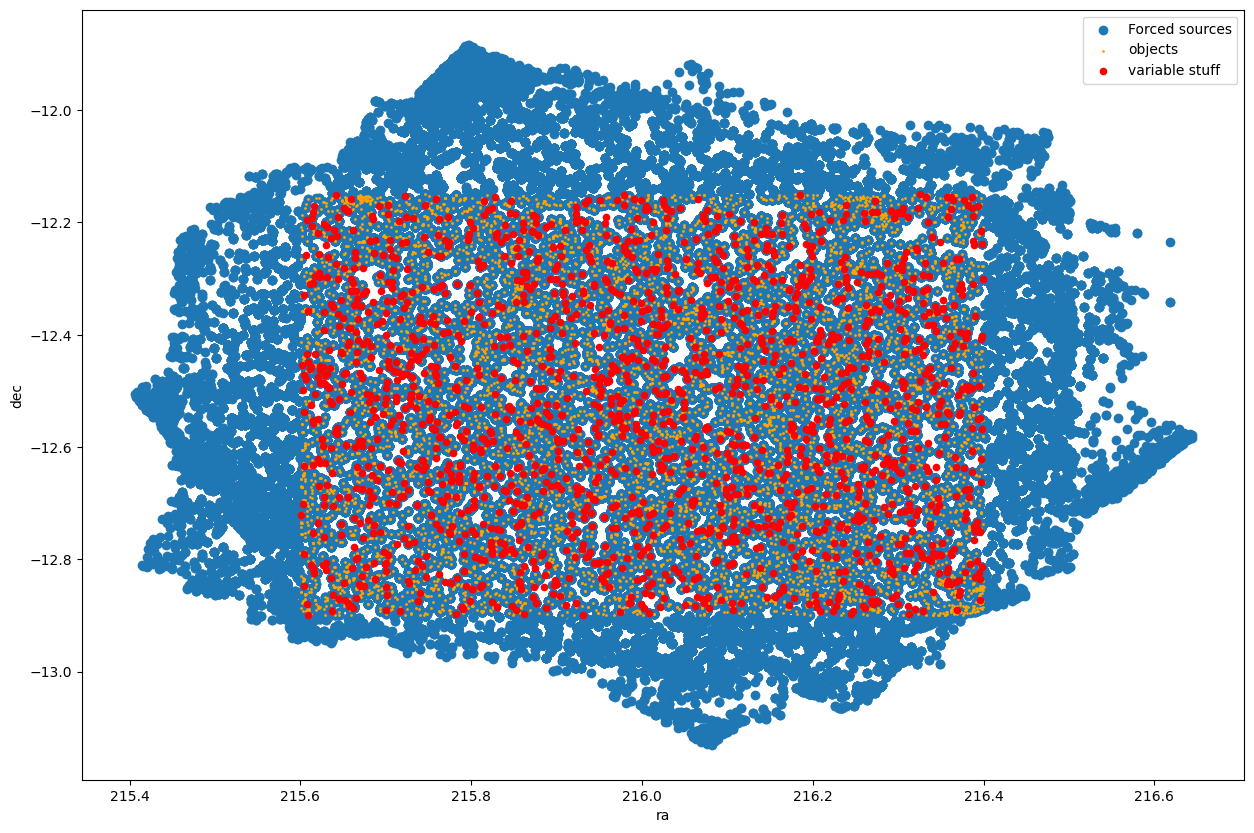

In [24]:
plt.figure(figsize=(15,10))

plt.scatter(srcForced4_field['ra'],srcForced4_field['dec'], label = 'Forced sources')
plt.scatter(obj4_field['ra'],obj4_field['dec'], s=1, color = 'orange', label = 'objects')
plt.scatter(tru_var_obj['ra'],tru_var_obj['dec'], color = 'red', label = 'variable stuff', s=20)
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()

# What actions should we use to clean up the dataset

### flags

In [25]:
# remove all objects for which any source has any flag
filtered_src4_field= src4_field[~src4_field[list_of_flags].any(axis=1)]
obj4_field_super_clean = obj4_field[obj4_field['diaObjectId'].isin(filtered_src4_field['diaObjectId'])]

In [26]:
len(obj4_field)

9942

In [27]:
len(obj4_field_super_clean)

4894

Text(0.5, 0, 'Number of sources per object')

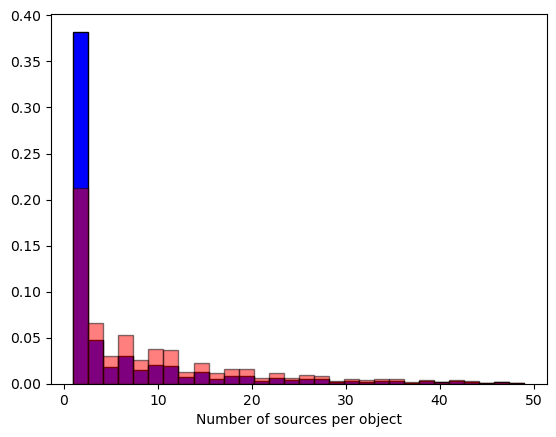

In [28]:
# histogram of the number of sources per objects, the ones that cleaned and not
plt.hist(obj4_field['nDiaSources'], bins=30, density=True, color='blue', edgecolor='black');
plt.hist(obj4_field_super_clean['nDiaSources'], bins=30, density=True, color='red', edgecolor='black', alpha=0.5);
plt.xlabel('Number of sources per object')


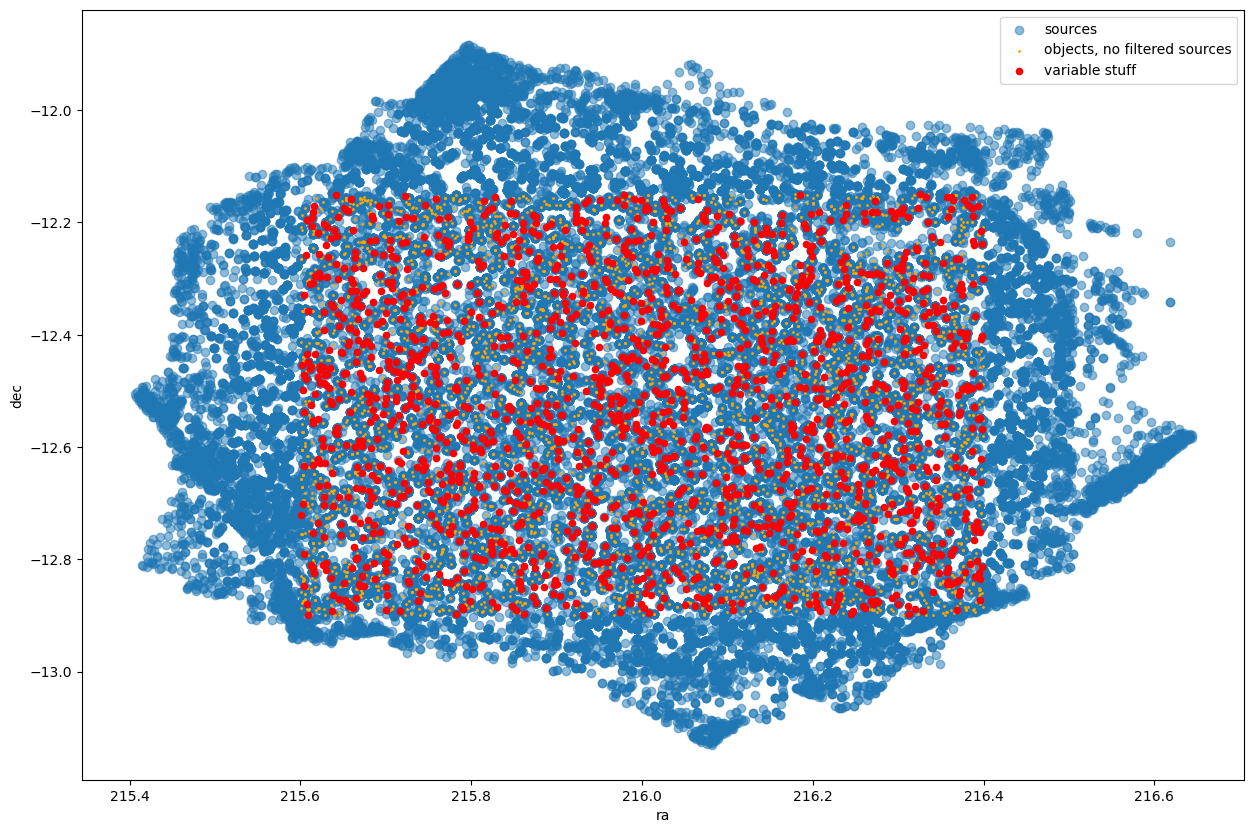

In [29]:
# show the subselection we made 

plt.figure(figsize=(15,10))

plt.scatter(src4_field['ra'],src4_field['dec'], label = 'sources', alpha=0.5)
plt.scatter(obj4_field_super_clean['ra'],obj4_field_super_clean['dec'], s=1, color = 'orange', label = 'objects, no filtered sources')
plt.scatter(tru_var_obj['ra'],tru_var_obj['dec'], color = 'red', label = 'variable stuff', s=20)
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()

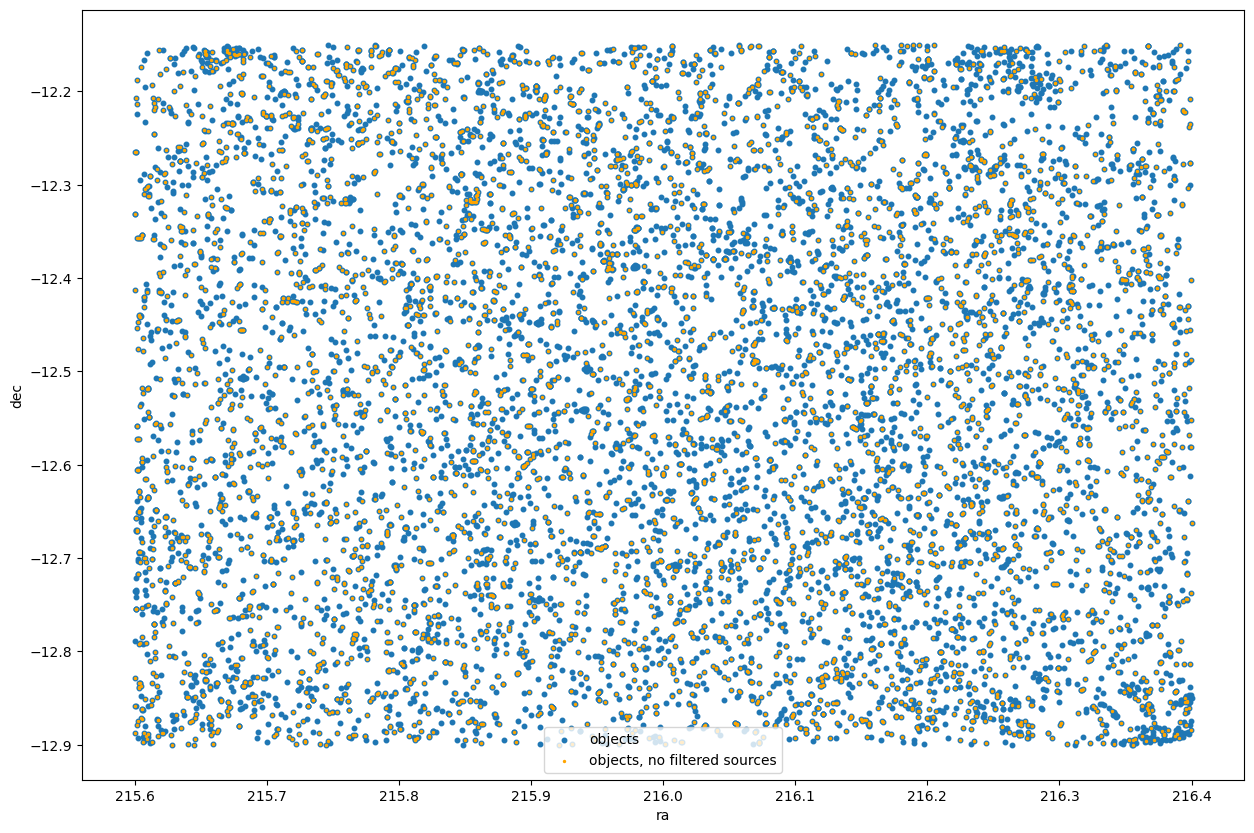

In [30]:
plt.figure(figsize=(15,10))

plt.scatter(obj4_field['ra'],obj4_field['dec'], label = 'objects', s=10.5)
plt.scatter(obj4_field_super_clean['ra'],obj4_field_super_clean['dec'], s=2, color = 'orange', label = 'objects, no filtered sources')
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()

In [31]:
list_of_flags

['centroid_flag',
 'apFlux_flag',
 'apFlux_flag_apertureTruncated',
 'psfFlux_flag',
 'psfFlux_flag_edge',
 'psfFlux_flag_noGoodPixels',
 'trail_flag_edge',
 'forced_PsfFlux_flag',
 'forced_PsfFlux_flag_edge',
 'forced_PsfFlux_flag_noGoodPixels',
 'shape_flag',
 'shape_flag_no_pixels',
 'shape_flag_not_contained',
 'shape_flag_parent_source',
 'pixelFlags',
 'pixelFlags_bad',
 'pixelFlags_cr',
 'pixelFlags_crCenter',
 'pixelFlags_edge',
 'pixelFlags_interpolated',
 'pixelFlags_interpolatedCenter',
 'pixelFlags_offimage',
 'pixelFlags_saturated',
 'pixelFlags_saturatedCenter',
 'pixelFlags_suspect',
 'pixelFlags_suspectCenter',
 'pixelFlags_streak',
 'pixelFlags_streakCenter',
 'pixelFlags_injected',
 'pixelFlags_injectedCenter',
 'pixelFlags_injected_template',
 'pixelFlags_injected_templateCenter']

In [32]:
# lets look at this one, as difImg limit is around 23.5
tru_var_obj_bright = tru_var_obj[tru_var_obj['magnorm'] < 23.5]
tru_var_obj_bright

,object_type,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,radial_velocity,parallax,variability_model,salt2_params,is_variable,period,mag_amplitude,phase
2423,star,1072180941,216.191984,-12.209090,0,21.491287,starSED/kurucz/km25_6000.fits_g30_6080.gz,3.1,0.273828,-2.670000,-1.510000,85.809998,0.050910,,None,True,6.915724,0.124658,3.876700
2424,star,250325369,216.162784,-12.201172,0,20.740699,starSED/phoSimMLT/lte037-5.5-1.0a+0.4.BT-Settl...,3.1,0.272701,-11.440000,-3.780000,6.960000,1.020000,,None,True,8.165801,0.879210,1.432904
2437,star,774753087,216.171834,-12.242497,0,20.432092,starSED/kurucz/km10_5250.fits_g15_5410.gz,3.1,0.273828,-0.250000,-5.520000,-2.620000,0.155239,,None,True,8.323236,0.613939,4.452022
2471,star,774752488,216.145104,-12.209442,0,19.986461,starSED/phoSimMLT/lte039-6.0-0.5a+0.2.BT-Settl...,3.1,0.271574,-16.469999,-26.530001,44.380001,1.079444,,None,True,0.395981,0.955521,0.744393
2485,star,774748554,216.134804,-12.276501,0,19.132947,starSED/kurucz/km15_5750.fits_g25_5990.gz,3.1,0.272701,-5.080000,-5.760000,28.049999,0.149348,,None,True,0.669193,0.607598,2.928880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172065,star,584556672,216.336481,-12.295612,0,22.160624,starSED/phoSimMLT/lte033-4.5-1.0a+0.4.BT-Settl...,3.1,0.285096,-17.639999,-12.180000,-87.580002,1.155580,,None,True,2.727213,0.849070,3.424665
172074,star,774767576,216.367692,-12.264789,0,23.013089,starSED/phoSimMLT/lte034-4.5-1.0a+0.4.BT-Settl...,3.1,0.285096,5.930000,-11.930000,49.790001,0.658264,,None,True,5.587030,0.344152,3.104635
172095,star,1072185411,216.331309,-12.272234,0,19.068648,starSED/kurucz/km20_6250.fits_g30_6270.gz,3.1,0.285096,-3.910000,-1.630000,297.429990,0.084411,,None,True,0.182028,0.656478,2.028350
174237,star,1072184172,216.377521,-12.399553,0,22.384865,starSED/kurucz/km15_5000.fits_g05_5060.gz,3.1,0.282842,-0.750000,-5.180000,-110.080000,0.098628,,None,True,0.161654,0.105586,1.369566


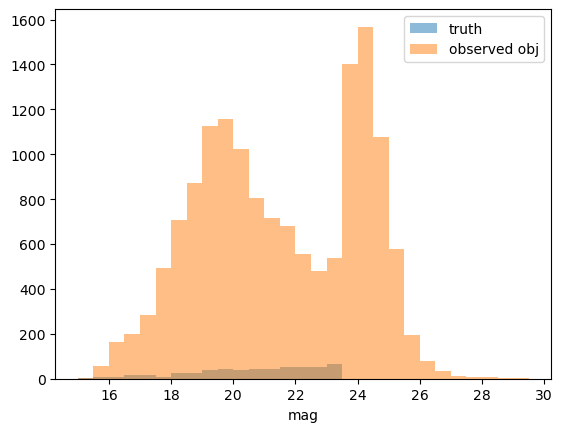

In [33]:
src4_field_mag, src4_field_magerr = create_mag_errors(src4_field['scienceFlux'], src4_field['scienceFluxErr'])
src4_field['science_mag'] = src4_field_mag

df_grouped = src4_field.groupby('diaObjectId').agg({
    'science_mag': 'mean',
    'diaSourceId': 'count'  # Optional: if you want to know the number of sources per object
}).reset_index()

# If you only need the 'diaObjectId' and mean 'scienceFlux', you can drop 'diaSourceId'
df_grouped = df_grouped[['diaObjectId', 'science_mag']]

plt.hist(tru_var_obj_bright['magnorm'],bins=np.arange(15, 30, 0.5), alpha=0.5, label='truth')
plt.hist(df_grouped['science_mag'],bins=np.arange(15, 30, 0.5), alpha=0.5, label='observed obj')

plt.xlabel('mag')
plt.legend()

In [34]:
obj4_field_merged = pd.merge(obj4_field, df_grouped[['diaObjectId', 'science_mag']], on='diaObjectId', how='left')
obj4_field_bright = obj4_field_merged[obj4_field_merged['science_mag'] < 23.5]


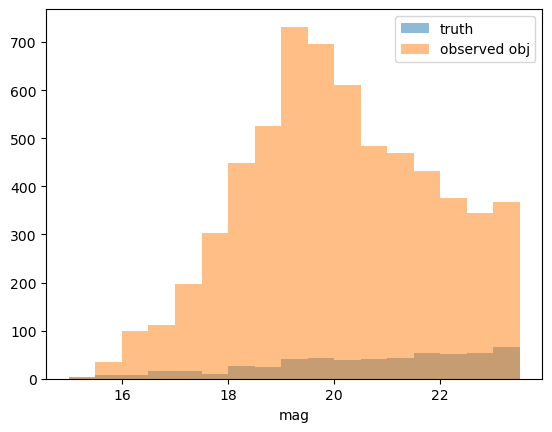

In [35]:
plt.hist(tru_var_obj_bright['magnorm'],bins=np.arange(15, 24, 0.5), alpha=0.5, label='truth')
plt.hist(obj4_field_bright['science_mag'],bins=np.arange(15, 24, 0.5), alpha=0.5, label='observed obj')

plt.xlabel('mag')
plt.legend()

In [36]:
# unit tests 

# if comparing to itself, should be 1 for both completness and purity
print(estimate_purity_completness(tru_var_obj, tru_var_obj))

# if taking only half of the true objects, should be 0.5 completness and 1 for purity
print(estimate_purity_completness(tru_var_obj[0:int(len(tru_var_obj)/2)], tru_var_obj))

# if offseting the ra so that half are out of match, it should be 0.5 for both
tru_var_obj_test = tru_var_obj.copy(deep=False)
tru_var_obj_test['ra'] = tru_var_obj_test['ra'] + np.random.uniform(0, 2/3600, len(tru_var_obj_test))
print(estimate_purity_completness(tru_var_obj_test, tru_var_obj))

(1.0, 1.0)
(1.0, 0.49971799210377893)
(0.5019740552735477, 0.5019740552735477)


In [37]:
tru_var_obj

,object_type,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,radial_velocity,parallax,variability_model,salt2_params,is_variable,period,mag_amplitude,phase
3,star,1009994123,216.207569,-12.180939,0,24.234124,starSED/kurucz/km15_4500.fits_g00_4680.gz,3.1,0.274954,-0.34,-2.50,38.580002,0.060423,,None,True,0.991257,0.103657,3.916524
2419,star,1072181022,216.190249,-12.202527,0,26.385021,starSED/kurucz/km30_4250.fits_g00_4330.gz,3.1,0.273828,-1.50,-2.19,208.200000,0.038548,,None,True,2.133275,0.620653,3.572403
2423,star,1072180941,216.191984,-12.209090,0,21.491287,starSED/kurucz/km25_6000.fits_g30_6080.gz,3.1,0.273828,-2.67,-1.51,85.809998,0.050910,,None,True,6.915724,0.124658,3.876700
2424,star,250325369,216.162784,-12.201172,0,20.740699,starSED/phoSimMLT/lte037-5.5-1.0a+0.4.BT-Settl...,3.1,0.272701,-11.44,-3.78,6.960000,1.020000,,None,True,8.165801,0.879210,1.432904
2437,star,774753087,216.171834,-12.242497,0,20.432092,starSED/kurucz/km10_5250.fits_g15_5410.gz,3.1,0.273828,-0.25,-5.52,-2.620000,0.155239,,None,True,8.323236,0.613939,4.452022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174234,star,930634037,216.379745,-12.405843,0,24.057310,starSED/phoSimMLT/lte032-4.5-1.0a+0.4.BT-Settl...,3.1,0.282842,-0.48,-7.38,8.530000,0.851922,,None,True,0.140427,0.427471,5.435825
174237,star,1072184172,216.377521,-12.399553,0,22.384865,starSED/kurucz/km15_5000.fits_g05_5060.gz,3.1,0.282842,-0.75,-5.18,-110.080000,0.098628,,None,True,0.161654,0.105586,1.369566
174238,star,774762453,216.380578,-12.396774,0,22.344290,starSED/kurucz/km30_4000.fits_g05_4200.gz,3.1,0.282842,-1.46,-1.73,-24.010000,0.240215,,None,True,6.917946,0.675635,3.769819
174265,star,774761880,216.372721,-12.395497,0,26.200310,starSED/phoSimMLT/lte032-4.5-1.0a+0.4.BT-Settl...,3.1,0.282842,-8.97,-1.31,-1.410000,0.329155,,None,True,0.390458,0.790919,4.527125


In [38]:
len(obj4_field)

9942

In [39]:
# no cleaning
print(estimate_purity_completness(obj4_field_bright, tru_var_obj_bright))

# Create a new DataFrame with random 'ra' and 'dec' values
df_random = pd.DataFrame({
    'ra': np.random.uniform(ra_min, ra_max, len(obj4_field_bright)),
    'dec': np.random.uniform(dec_min, dec_max, len(obj4_field_bright))
})

print(estimate_purity_completness(df_random, tru_var_obj_bright))

(0.08164902149502727, 0.9121863799283154)
(0.0, 0.0)


In [40]:
# remove all objects for which any source has any flag
filtered_src4_field= src4_field[~src4_field[list_of_flags].any(axis=1)]
obj4_field_super_clean = obj4_field_bright[obj4_field_bright['diaObjectId'].isin(filtered_src4_field['diaObjectId'])]

# without objects for which any source has any flags
estimate_purity_completness(obj4_field_super_clean, tru_var_obj_bright)

(0.07700394218134034, 0.525089605734767)

In [41]:
# more than 10 observations in any band
obj4_field_more_obs = obj4_field_bright[obj4_field_bright['nDiaSources']>10]
estimate_purity_completness(obj4_field_more_obs, tru_var_obj_bright)

(0.2472934472934473, 0.7777777777777778)

In [42]:
band_counts = src4_field.groupby(['diaObjectId', 'band']).size().unstack(fill_value=0)
# Rename the columns in band_counts
band_counts_renamed = band_counts.rename(columns={
    'g': 'nDiaSources_g',
    'r': 'nDiaSources_r',
    'i': 'nDiaSources_i'
})
# Merge obj4_field with band_counts on diaObjectId
obj4_field_with_band_counts = pd.merge(obj4_field_bright, band_counts_renamed, on='diaObjectId', how='left')

# If needed, fill NaN values with 0 (in case some diaObjectId in obj4_field doesn't exist in band_counts)
obj4_field_with_band_counts = obj4_field_with_band_counts.fillna(0)

In [43]:
# at least one observation in each band
obj4_field_at_least_1_in_band = obj4_field_with_band_counts[(obj4_field_with_band_counts['nDiaSources_g']>1) & (obj4_field_with_band_counts['nDiaSources_r']>1) & (obj4_field_with_band_counts['nDiaSources_i']>1)]
estimate_purity_completness(obj4_field_at_least_1_in_band, tru_var_obj_bright)

(0.24293405114401076, 0.6469534050179212)

In [44]:
# a bit more systematic - testing each flag separately

list_of_pur_comp_as_function_of_flags = []
for i in range(len(list_of_flags)):
    # remove all objects for which any source has one flag
    filtered_src4_field= src4_field[~src4_field[[list_of_flags[i]]].any(axis=1)]
    obj4_field_one_flag_cleaned = obj4_field_bright[obj4_field_bright['diaObjectId'].isin(filtered_src4_field['diaObjectId'])]
    list_of_pur_comp_as_function_of_flags.append(estimate_purity_completness(obj4_field_one_flag_cleaned, tru_var_obj_bright))

arr_of_pur_comp_as_function_of_flags = np.array(list_of_pur_comp_as_function_of_flags)

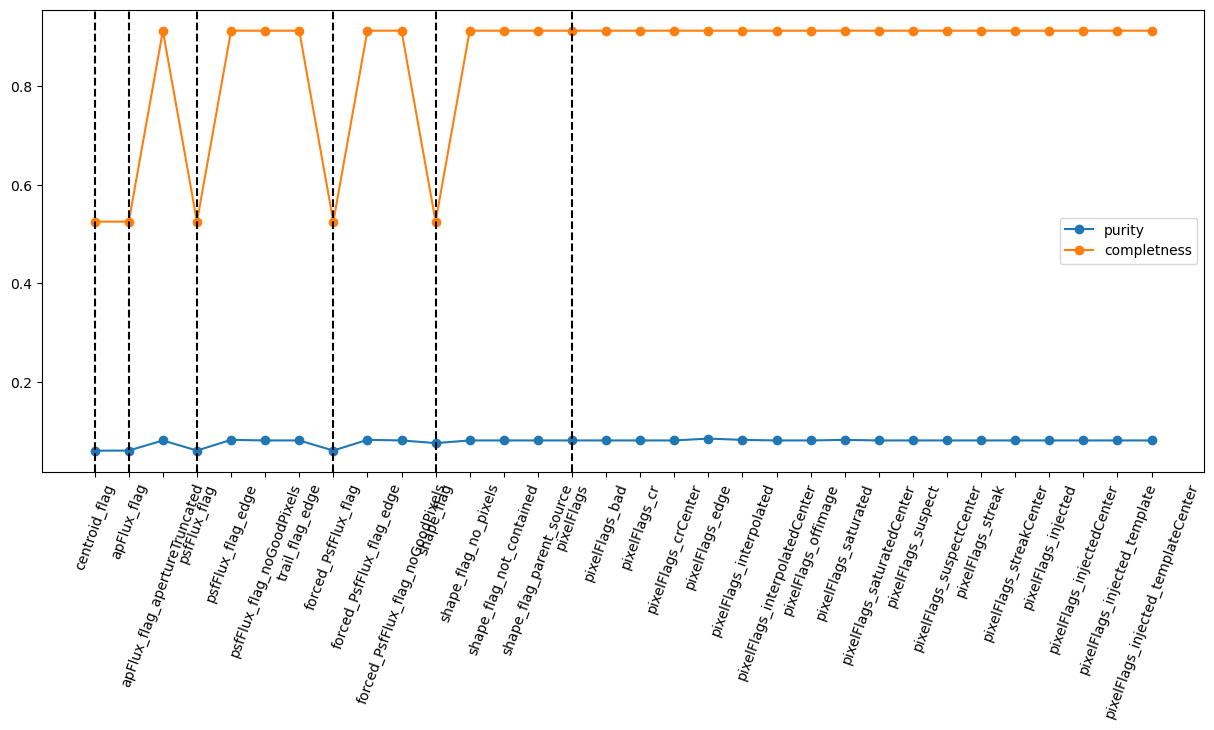

In [45]:
plt.figure(figsize=(15,6)) 
plt.plot(arr_of_pur_comp_as_function_of_flags[:,0], label='purity', marker='o')
plt.plot(arr_of_pur_comp_as_function_of_flags[:,1], label='completness', marker='o')
plt.axvline(x=0, color='k', ls = '--')
plt.axvline(x=1, color='k', ls = '--')
plt.axvline(x=3, color='k', ls = '--')
plt.axvline(x=7, color='k', ls = '--')
plt.axvline(x=10, color='k', ls = '--')
plt.axvline(x=14, color='k', ls = '--')

plt.legend()
plt.xticks(range(len(list_of_flags)), list_of_flags, rotation=70);

In [46]:
src4_field.columns


Index(['diaSourceId', 'diaObjectId', 'ra', 'dec', 'midpointMjdTai', 'psfFlux',
       'psfFluxErr', 'scienceFlux', 'scienceFluxErr', 'snr', 'band',
       'time_processed', 'time_withdrawn', 'centroid_flag', 'apFlux_flag',
       'apFlux_flag_apertureTruncated', 'psfFlux_flag', 'psfFlux_flag_edge',
       'psfFlux_flag_noGoodPixels', 'trail_flag_edge', 'forced_PsfFlux_flag',
       'forced_PsfFlux_flag_edge', 'forced_PsfFlux_flag_noGoodPixels',
       'shape_flag', 'shape_flag_no_pixels', 'shape_flag_not_contained',
       'shape_flag_parent_source', 'pixelFlags', 'pixelFlags_bad',
       'pixelFlags_cr', 'pixelFlags_crCenter', 'pixelFlags_edge',
       'pixelFlags_interpolated', 'pixelFlags_interpolatedCenter',
       'pixelFlags_offimage', 'pixelFlags_saturated',
       'pixelFlags_saturatedCenter', 'pixelFlags_suspect',
       'pixelFlags_suspectCenter', 'pixelFlags_streak',
       'pixelFlags_streakCenter', 'pixelFlags_injected',
       'pixelFlags_injectedCenter', 'pixelFlags_inje

(0.0, 1.0)

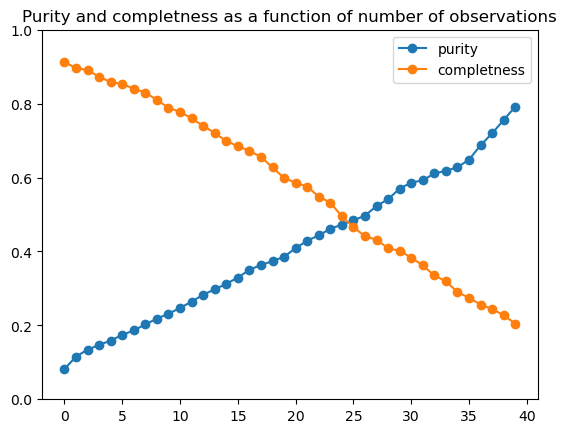

In [47]:
list_of_pur_comp_as_function_of_nobs = []
for i in range(40):
    # more than 10 observations in any band
    obj4_field_more_obs = obj4_field_bright[obj4_field_bright['nDiaSources']>i]
    list_of_pur_comp_as_function_of_nobs.append(estimate_purity_completness(obj4_field_more_obs, tru_var_obj_bright))
    
arr_of_pur_comp_as_function_of_nobs = np.array(list_of_pur_comp_as_function_of_nobs)

plt.plot(arr_of_pur_comp_as_function_of_nobs[:,0], label='purity', marker='o')
plt.plot(arr_of_pur_comp_as_function_of_nobs[:,1], label='completness', marker='o')
plt.legend()
plt.title('Purity and completness as a function of number of observations')
plt.ylim(0,1)

Text(0.5, 1.0, 'Purity and completness as a function of snr')

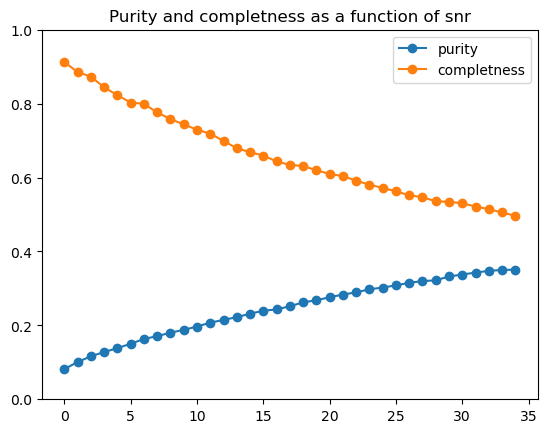

In [48]:
list_of_pur_comp_as_function_of_snr = []
for i in range(5,40):
    # more than 10 observations in any band
    obj4_field_filtered = obj4_field_bright[obj4_field_bright['diaObjectId'].isin(src4_field[src4_field['snr'] > i]['diaObjectId'].unique())]
    list_of_pur_comp_as_function_of_snr.append(estimate_purity_completness(obj4_field_filtered, tru_var_obj_bright))
    
list_of_pur_comp_as_function_of_snr = np.array(list_of_pur_comp_as_function_of_snr)

arr_of_pur_comp_as_function_of_snr = np.array(list_of_pur_comp_as_function_of_snr)

plt.plot(arr_of_pur_comp_as_function_of_snr[:,0], label='purity', marker='o')
plt.plot(arr_of_pur_comp_as_function_of_snr[:,1], label='completness', marker='o')
plt.ylim(0,1)
plt.legend()
plt.title('Purity and completness as a function of snr')



In [48]:
# it would be useful to have diffimLimitingMagnitude
# total number of obs possible at this point

### forced?

In [49]:
obj4_field

,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxPercentile95,y_psfFluxMin,y_psfFluxMax,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources
153210,3068394109505896606,2024-06-26 02:48:25+00:00,None,215.889039,NaN,-12.896901,NaN,NaN,60487.114560,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:26:12+00:00,5
153235,3068394109505896635,2024-06-26 02:52:34+00:00,None,215.948394,2.019397e-05,-12.894802,9.924860e-06,-1.183491e-10,60487.117363,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:51:18+00:00,7
153238,3068394109505896638,2024-06-26 02:54:17+00:00,None,215.922383,5.851012e-07,-12.885339,6.303400e-07,1.301129e-14,60487.118303,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:52:34+00:00,23
153239,3068394109505896639,2024-06-26 02:58:21+00:00,None,215.966875,8.505353e-06,-12.899532,1.858597e-05,9.602694e-11,60487.118303,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:52:34+00:00,15
153244,3068394109505896644,2024-06-26 02:50:38+00:00,None,215.937075,NaN,-12.884774,NaN,NaN,60487.115963,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:26:12+00:00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171475,3068394172890218525,2024-06-26 02:55:53+00:00,None,215.635087,NaN,-12.360875,NaN,NaN,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171477,3068394172890218554,2024-06-26 02:55:53+00:00,None,215.690908,3.625022e-05,-12.306796,2.220503e-05,4.035649e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171478,3068394172890218581,2024-06-26 02:55:53+00:00,None,215.665284,2.192825e-05,-12.264642,4.064201e-05,-5.401110e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171479,3068394172890218585,2024-06-26 02:55:53+00:00,None,215.677023,2.335178e-05,-12.260069,2.930849e-05,-1.390424e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1


In [50]:
single_srcForced = srcForced4_field[srcForced4_field['diaObjectId']==obj4_field['diaObjectId'].iloc[0]]
single_src = src4_field[src4_field['diaObjectId']==obj4_field['diaObjectId'].iloc[0]]
len(single_srcForced)
len(single_src)

5

In [51]:
# Define a function to compute the lengths for each row
def compute_lengths(row):
    single_srcForced = srcForced4_field[srcForced4_field['diaObjectId'] == row['diaObjectId']]
    single_src = src4_field[src4_field['diaObjectId'] == row['diaObjectId']]
    row['num_single_srcForced'] = len(single_srcForced)
    row['num_single_src'] = len(single_src)
    return row

# Apply the function to each row in obj4_field
obj4_field_bright = obj4_field_bright.apply(compute_lengths, axis=1)

Text(0, 0.5, 'num_single_srcForced')

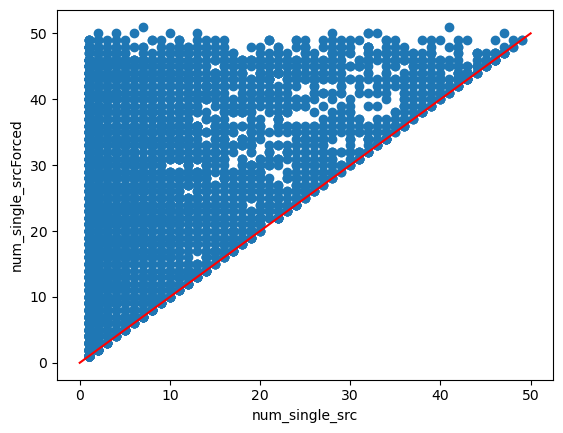

In [52]:
plt.scatter(obj4_field_bright['num_single_src'], obj4_field_bright['num_single_srcForced'])
plt.plot([0, 50], [0, 50], color='red')
plt.xlabel('num_single_src')
plt.ylabel('num_single_srcForced')

In [53]:
obj4_field_bright, tru_var_obj_bright

(              diaObjectId             validityStart validityEnd          ra  \
 0     3068394109505896606 2024-06-26 02:48:25+00:00        None  215.889039   
 1     3068394109505896635 2024-06-26 02:52:34+00:00        None  215.948394   
 2     3068394109505896638 2024-06-26 02:54:17+00:00        None  215.922383   
 3     3068394109505896639 2024-06-26 02:58:21+00:00        None  215.966875   
 4     3068394109505896644 2024-06-26 02:50:38+00:00        None  215.937075   
 ...                   ...                       ...         ...         ...   
 9919  3068394172881830039 2024-06-26 02:55:37+00:00        None  216.199977   
 9921  3068394172886024208 2024-06-26 02:55:40+00:00        None  215.954336   
 9928  3068394172886024297 2024-06-26 02:55:40+00:00        None  215.846866   
 9933  3068394172886024343 2024-06-26 02:55:40+00:00        None  215.904233   
 9935  3068394172890218511 2024-06-26 02:55:53+00:00        None  215.739180   
 
              raErr        dec        

In [76]:

step_nobs = 2
step_frac_forced = 0.1
list_of_pur_comp_as_function_of_frac_Forced = []
for j in range(0, 52, step_nobs):
    for i in np.linspace(0, 1, 10):
        # more than 10 observations in any band
        # only select those where the number of sources is more than half of the number of forced sources
        obj4_field_many_src = obj4_field_bright[(obj4_field_bright['num_single_src'] > (obj4_field_bright['num_single_srcForced'] * i)) & (obj4_field_bright['num_single_src'] > j)]
        try:
            list_of_pur_comp_as_function_of_frac_Forced.append([j, i, estimate_purity_completness(obj4_field_many_src, tru_var_obj_bright)])
        except:
            list_of_pur_comp_as_function_of_frac_Forced.append([j, i, (np.nan, np.nan)])
    
# arr_of_pur_comp_as_function_of_frac_Forced = np.array(list_of_pur_comp_as_function_of_frac_Forced)

list_of_pur_comp_as_function_of_frac_Forced = [[a, b, c, d] for a, b, (c, d) in list_of_pur_comp_as_function_of_frac_Forced]

arr_of_pur_comp_as_function_of_frac_Forced = np.array(list_of_pur_comp_as_function_of_frac_Forced)


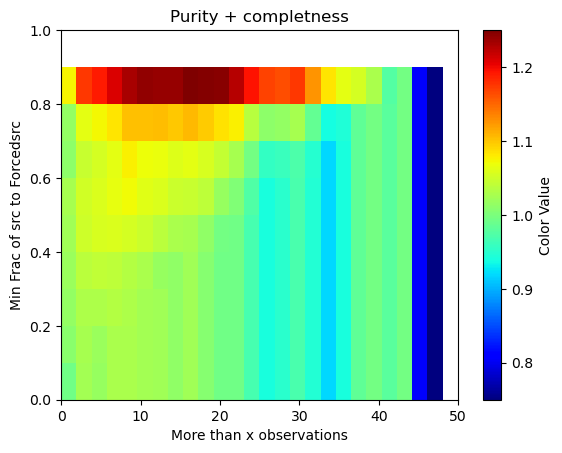

In [78]:
# Slice the array to get the first three columns
data_to_plot = arr_of_pur_comp_as_function_of_frac_Forced[:, :3]


# Extract the columns
x_values = arr_of_pur_comp_as_function_of_frac_Forced[:, 0]
y_values = arr_of_pur_comp_as_function_of_frac_Forced[:, 1]
color_values = arr_of_pur_comp_as_function_of_frac_Forced[:, 2] + arr_of_pur_comp_as_function_of_frac_Forced[:, 3]

# Create a meshgrid for x and y values
x_unique = np.unique(x_values)
y_unique = np.unique(y_values)
X, Y = np.meshgrid(x_unique, y_unique)

# Reshape the color values to match the meshgrid
Z = color_values.reshape(len(x_unique),len(y_unique) ).T

# Plot with plt.imshow
plt.imshow(Z, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()), origin='lower', aspect='auto', cmap='jet', vmin=0.75, vmax=1.25)

# Add colorbar and labels
plt.colorbar(label='Color Value')
plt.xlabel('More than x observations')
plt.ylabel('Min Frac of src to Forcedsrc')
plt.title('Purity + completness')

# Show the plot
plt.show()

In [55]:
#What happens at high fraction and more 30+ observations
# bascially completness starts dropping

obj4_field_many_src_09_48 = obj4_field_bright[(obj4_field_bright['num_single_src'] > (obj4_field_bright['num_single_srcForced'] * 0.9)) & (obj4_field_bright['num_single_src'] > 48)]
obj4_field_many_src_09_20 = obj4_field_bright[(obj4_field_bright['num_single_src'] > (obj4_field_bright['num_single_srcForced'] * 0.9)) & (obj4_field_bright['num_single_src'] > 20)]

In [56]:
estimate_purity_completness(obj4_field_many_src_09_48, tru_var_obj_bright)

(0.5, 0.0017921146953405018)

In [57]:
# lets have a look at the objects; one of them is fake!??!
obj4_field_many_src_09_48

,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources,science_mag,num_single_srcForced,num_single_src
590,3068394109518479520,2024-06-26 02:55:37+00:00,None,216.054147,NaN,-12.628852,NaN,NaN,60487.119709,None,...,None,None,None,None,None,2024-06-26 02:55:16+00:00,49,20.320304,49,49
760,3068394109522673751,2024-06-26 02:56:33+00:00,None,215.933222,0.000006,-12.634665,0.000006,-1.462440e-13,60487.119709,None,...,None,None,None,None,None,2024-06-26 02:55:16+00:00,49,22.687555,49,49


In [82]:
single_src = src4_field[src4_field['diaObjectId']==3068394109522673751]


In [83]:
single_src['psfFlux']

24       5617.488770
1458     5468.565430
4139     5794.506836
5228     5693.467285
8202     5892.519531
9303     5747.052246
11102    5378.031738
12943    5830.538086
14893    5917.032227
17860    1352.776611
18717    1511.409302
19487    1488.810303
20559    1548.899780
22301    1255.300049
23574    1537.114868
24432    1361.629028
25321    1518.431763
26376    1583.532593
28997    1406.082397
29915    1620.611328
32078    1498.895142
32690    1358.375244
35682    1532.223511
36177    1930.641357
37937    4264.520996
39782    4371.130859
40466    3951.182129
42451    4220.676758
43460    4419.724121
45383    4499.615234
46328    3951.117188
48333    4357.270020
49155    3921.925781
52224    4325.582520
53404    4175.837402
55051    4492.355957
56532    3734.413086
58032    4108.454102
58985    4194.906250
60568    4446.347168
61562    4218.543457
63497    4317.166992
65237    4244.883789
66779    1603.749756
67985    1858.025879
69725    1212.626343
70756    5708.987305
73282    5356

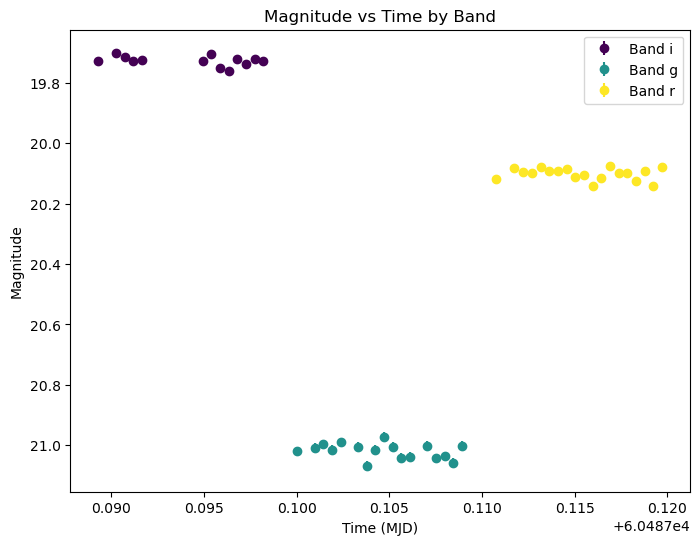

In [58]:
single_srcForced = srcForced4_field[srcForced4_field['diaObjectId']==3068394109518479520]
single_src = src4_field[src4_field['diaObjectId']==3068394109518479520]
t1 = single_src['midpointMjdTai']
mag1, err1 = create_mag_errors(single_src['scienceFlux'], single_src['scienceFluxErr'])

# Extract band information (assuming it's a column in the dataframe)
bands = single_src['band']

# Define unique colors for each band
unique_bands = bands.unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_bands)))

# Plot each band with a different color
plt.figure(figsize=(8, 6))

for band, color in zip(unique_bands, colors):
    # Filter data for the current band
    band_mask = bands == band
    t_band = t1[band_mask]
    mag_band = mag1[band_mask]
    err_band = err1[band_mask]
    
    # Plot data for the current band
    plt.errorbar(t_band, mag_band, yerr=err_band, fmt='o', color=color, label=f'Band {band}')

# Customize the plot
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes (as is common in astronomy)
plt.xlabel('Time (MJD)')
plt.ylabel('Magnitude')
plt.title('Magnitude vs Time by Band')
plt.legend()




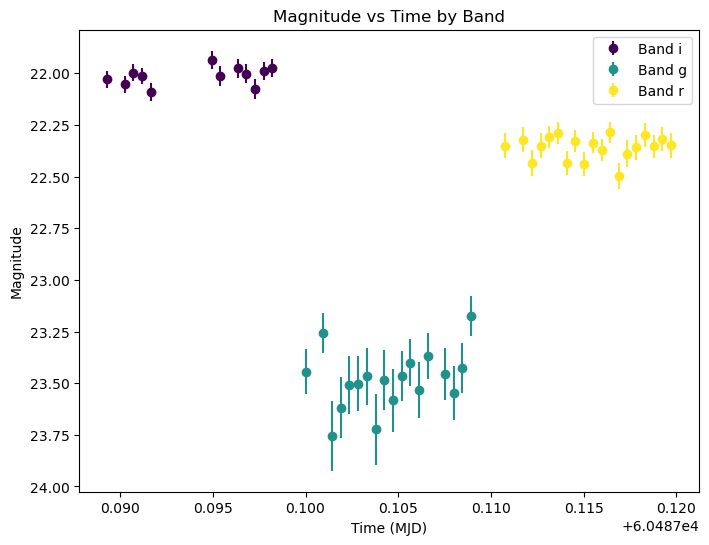

In [59]:
single_srcForced = srcForced4_field[srcForced4_field['diaObjectId']==3068394109522673751]
single_src = src4_field[src4_field['diaObjectId']==3068394109522673751]
t1 = single_src['midpointMjdTai']
mag1, err1 = create_mag_errors(single_src['scienceFlux'], single_src['scienceFluxErr'])

# Extract band information (assuming it's a column in the dataframe)
bands = single_src['band']

# Define unique colors for each band
unique_bands = bands.unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_bands)))

# Plot each band with a different color
plt.figure(figsize=(8, 6))

for band, color in zip(unique_bands, colors):
    # Filter data for the current band
    band_mask = bands == band
    t_band = t1[band_mask]
    mag_band = mag1[band_mask]
    err_band = err1[band_mask]
    
    # Plot data for the current band
    plt.errorbar(t_band, mag_band, yerr=err_band, fmt='o', color=color, label=f'Band {band}')

# Customize the plot
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes (as is common in astronomy)
plt.xlabel('Time (MJD)')
plt.ylabel('Magnitude')
plt.title('Magnitude vs Time by Band')
plt.legend()



In [60]:
print(list(obj4_field.columns))

['diaObjectId', 'validityStart', 'validityEnd', 'ra', 'raErr', 'dec', 'decErr', 'ra_dec_Cov', 'radecMjdTai', 'pmRa', 'pmRaErr', 'pmDec', 'pmDecErr', 'parallax', 'parallaxErr', 'pmRa_pmDec_Cov', 'pmRa_parallax_Cov', 'pmDec_parallax_Cov', 'pmParallaxLnL', 'pmParallaxChi2', 'pmParallaxNdata', 'u_psfFluxMean', 'u_psfFluxMeanErr', 'u_psfFluxSigma', 'u_psfFluxChi2', 'u_psfFluxNdata', 'u_fpFluxMean', 'u_fpFluxMeanErr', 'u_fpFluxSigma', 'g_psfFluxMean', 'g_psfFluxMeanErr', 'g_psfFluxSigma', 'g_psfFluxChi2', 'g_psfFluxNdata', 'g_fpFluxMean', 'g_fpFluxMeanErr', 'g_fpFluxSigma', 'r_psfFluxMean', 'r_psfFluxMeanErr', 'r_psfFluxSigma', 'r_psfFluxChi2', 'r_psfFluxNdata', 'r_fpFluxMean', 'r_fpFluxMeanErr', 'r_fpFluxSigma', 'i_psfFluxMean', 'i_psfFluxMeanErr', 'i_psfFluxSigma', 'i_psfFluxChi2', 'i_psfFluxNdata', 'i_fpFluxMean', 'i_fpFluxMeanErr', 'i_fpFluxSigma', 'z_psfFluxMean', 'z_psfFluxMeanErr', 'z_psfFluxSigma', 'z_psfFluxChi2', 'z_psfFluxNdata', 'z_fpFluxMean', 'z_fpFluxMeanErr', 'z_fpFluxSigma',

### Combo of flags and fraction 

In [61]:
# Add fraction of flagged sources to obj4_field_bright
def calculate_true_flag_fraction(obj4_field_bright, src4_field, list_of_flags):
    # Merge the two dataframes on 'diaObjectId'
    merged_df = pd.merge(src4_field, obj4_field_bright[['diaObjectId']], on='diaObjectId')

    # For each row in merged_df, check if any of the flags in list_of_flags are True
    merged_df['any_flag_true'] = merged_df[list_of_flags].any(axis=1)

    # Group by 'diaObjectId' and calculate the fraction of rows where 'any_flag_true' is True
    result = merged_df.groupby('diaObjectId')['any_flag_true'].mean().reset_index()

    # Rename the column to indicate it's the fraction of TRUE flags
    result.rename(columns={'any_flag_true': 'true_flag_fraction'}, inplace=True)

    return result

result_df = calculate_true_flag_fraction(obj4_field_bright, src4_field, list_of_flags)
result_df

result_df['false_flag_fraction']= 1 - result_df['true_flag_fraction']

obj4_field_bright_with_fraction = pd.merge(obj4_field_bright, result_df, on='diaObjectId', how='left')

In [62]:
result_df

,diaObjectId,true_flag_fraction,false_flag_fraction
0,3068394109505896606,0.800000,0.200000
1,3068394109505896635,0.714286,0.285714
2,3068394109505896638,0.347826,0.652174
3,3068394109505896639,0.800000,0.200000
4,3068394109505896644,1.000000,0.000000
...,...,...,...
6229,3068394172881830039,1.000000,0.000000
6230,3068394172886024208,0.000000,1.000000
6231,3068394172886024297,0.000000,1.000000
6232,3068394172886024343,1.000000,0.000000


In [63]:
obj4_field_bright_with_fraction['src_src_forced_fraction'] = (
    obj4_field_bright_with_fraction['num_single_src'] / 
    obj4_field_bright_with_fraction['num_single_srcForced'].replace(0, float('nan'))
)

# Replace any NaN values resulting from division by zero with 0
obj4_field_bright_with_fraction['src_src_forced_fraction'].fillna(0, inplace=True)

In [64]:
# Things that I notice here!
# lastNonForcedSource - 1970-01-01 00:00:00+00:00	
# raErr, decErr equal to Nan

In [65]:
obj4_field_bright_with_fraction

,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources,science_mag,num_single_srcForced,num_single_src,true_flag_fraction,false_flag_fraction,src_src_forced_fraction
0,3068394109505896606,2024-06-26 02:48:25+00:00,None,215.889039,NaN,-12.896901,NaN,NaN,60487.114560,None,...,None,None,2024-06-26 02:26:12+00:00,5,19.492664,17,5,0.800000,0.200000,0.294118
1,3068394109505896635,2024-06-26 02:52:34+00:00,None,215.948394,2.019397e-05,-12.894802,9.924860e-06,-1.183491e-10,60487.117363,None,...,None,None,2024-06-26 02:51:18+00:00,7,19.302939,20,7,0.714286,0.285714,0.350000
2,3068394109505896638,2024-06-26 02:54:17+00:00,None,215.922383,5.851012e-07,-12.885339,6.303400e-07,1.301129e-14,60487.118303,None,...,None,None,2024-06-26 02:52:34+00:00,23,16.270368,23,23,0.347826,0.652174,1.000000
3,3068394109505896639,2024-06-26 02:58:21+00:00,None,215.966875,8.505353e-06,-12.899532,1.858597e-05,9.602694e-11,60487.118303,None,...,None,None,2024-06-26 02:52:34+00:00,15,18.324083,21,15,0.800000,0.200000,0.714286
4,3068394109505896644,2024-06-26 02:50:38+00:00,None,215.937075,NaN,-12.884774,NaN,NaN,60487.115963,None,...,None,None,2024-06-26 02:26:12+00:00,4,22.151005,23,4,1.000000,0.000000,0.173913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,3068394172881830039,2024-06-26 02:55:37+00:00,None,216.199977,3.419452e-05,-12.165984,4.641237e-05,-4.300626e-11,60487.119709,None,...,None,None,1970-01-01 00:00:00+00:00,1,21.876177,2,1,1.000000,0.000000,0.500000
6230,3068394172886024208,2024-06-26 02:55:40+00:00,None,215.954336,4.483608e-05,-12.381593,7.658424e-05,-1.778108e-10,60487.119709,None,...,None,None,1970-01-01 00:00:00+00:00,1,21.884804,1,1,0.000000,1.000000,1.000000
6231,3068394172886024297,2024-06-26 02:55:40+00:00,None,215.846866,5.645906e-05,-12.264648,5.082778e-05,3.469363e-11,60487.119709,None,...,None,None,1970-01-01 00:00:00+00:00,1,22.654691,1,1,0.000000,1.000000,1.000000
6232,3068394172886024343,2024-06-26 02:55:40+00:00,None,215.904233,NaN,-12.194918,NaN,NaN,60487.119709,None,...,None,None,1970-01-01 00:00:00+00:00,1,21.337169,1,1,1.000000,0.000000,1.000000


In [66]:
src4_field[src4_field['diaObjectId']==3068394109505896606]

,diaSourceId,diaObjectId,ra,dec,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,snr,...,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,reliability,science_mag
7586,3068394125616218152,3068394109505896606,215.888979,-12.896907,60487.096341,-2088.977051,351.734070,71139.984375,342.842651,5.840071,...,False,False,False,False,False,False,False,False,None,19.269716
16000,3068394109505896606,3068394109505896606,215.888972,-12.896921,60487.089310,-3672.667236,339.154877,69499.117188,323.690247,10.942198,...,False,False,False,False,False,False,False,False,None,19.295052
47699,3068394161049698442,3068394109505896606,215.889199,-12.896842,60487.114560,1518.954346,249.890167,26202.498047,234.999908,6.126752,...,False,False,False,False,False,False,False,False,None,20.354143
73813,3068394122394992651,3068394109505896606,215.889017,-12.896904,60487.094933,-2111.126953,358.514618,71827.578125,347.878662,5.940053,...,False,False,False,False,False,False,False,False,None,19.259272
75365,3068394123468734471,3068394109505896606,215.889027,-12.896933,60487.095400,-2609.350098,354.674591,70136.687500,346.346741,7.377178,...,False,False,False,False,False,False,False,False,None,19.285137


In [67]:
step_frac_flag = 0.1
step_frac_forced = 0.1
list_of_pur_comp_as_function_of_frac_Forced = []
for j in np.linspace(0, 1, 10):
    for i in np.linspace(0, 1, 10):
        # only select those where the number of sources is more than some fraction of the number of forced sources
        # only select those where the number of nonflagged - sources is more than some fraction of all sources
        obj4_field_many_src = obj4_field_bright_with_fraction[(obj4_field_bright_with_fraction['src_src_forced_fraction'] >=  i) & (obj4_field_bright_with_fraction['false_flag_fraction'] >=j)]
        try:
            list_of_pur_comp_as_function_of_frac_Forced.append([j, i, estimate_purity_completness(obj4_field_many_src, tru_var_obj_bright)])
        except:
            list_of_pur_comp_as_function_of_frac_Forced.append([j, i, (np.nan, np.nan)])
    
    
list_of_pur_comp_as_function_of_frac_Forced_frac_true = [[a, b, c, d] for a, b, (c, d) in list_of_pur_comp_as_function_of_frac_Forced]

arr_of_pur_comp_as_function_of_frac_Forced_frac_true = np.array(list_of_pur_comp_as_function_of_frac_Forced_frac_true)

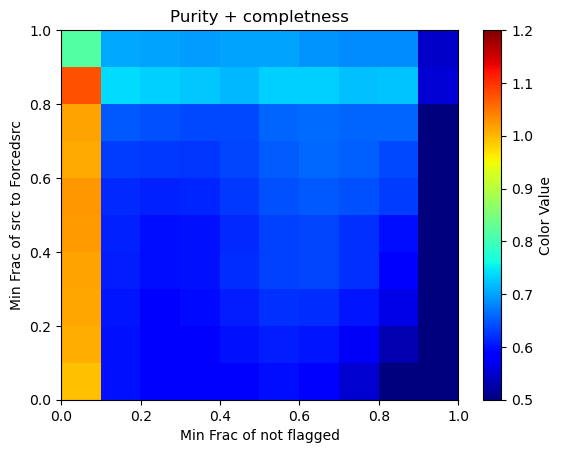

In [68]:


# Slice the array to get the first three columns
data_to_plot = arr_of_pur_comp_as_function_of_frac_Forced[:, :3]


# Extract the columns
x_values = arr_of_pur_comp_as_function_of_frac_Forced_frac_true[:, 0]
y_values = arr_of_pur_comp_as_function_of_frac_Forced_frac_true[:, 1]
color_values = arr_of_pur_comp_as_function_of_frac_Forced_frac_true[:, 2] + arr_of_pur_comp_as_function_of_frac_Forced_frac_true[:, 3]

# Create a meshgrid for x and y values
x_unique = np.unique(x_values)
y_unique = np.unique(y_values)
X, Y = np.meshgrid(x_unique, y_unique)

# Reshape the color values to match the meshgrid
Z = color_values.reshape(len(x_unique),len(y_unique) ).T

# Plot with plt.imshow
plt.imshow(Z, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()), origin='lower', aspect='auto', cmap='jet', vmin=0.5, vmax=1.2)

# Add colorbar and labels
plt.colorbar(label='Color Value')
plt.xlabel('Min Frac of not flagged')
plt.ylabel('Min Frac of src to Forcedsrc')
plt.title('Purity + completness')

# Show the plot
plt.show()

In [69]:
obj4_field_best_case = obj4_field_bright_with_fraction[(obj4_field_bright_with_fraction['src_src_forced_fraction'] >=  0.0) & (obj4_field_bright_with_fraction['false_flag_fraction'] >= 0)]
estimate_purity_completness(obj4_field_best_case, tru_var_obj_bright)

(0.08164902149502727, 0.9121863799283154)

In [70]:
obj4_field_best_case = obj4_field_bright_with_fraction[(obj4_field_bright_with_fraction['src_src_forced_fraction'] >=  0.90) & (obj4_field_bright_with_fraction['false_flag_fraction'] >= 0)]
estimate_purity_completness(obj4_field_best_case, tru_var_obj_bright)

(0.48520710059171596, 0.5878136200716846)

In [71]:
obj4_field_best_case = obj4_field_bright_with_fraction[(obj4_field_bright_with_fraction['src_src_forced_fraction'] >=  0.9) & (obj4_field_bright_with_fraction['false_flag_fraction'] >= 0.01)]
estimate_purity_completness(obj4_field_best_case, tru_var_obj_bright)

(0.4139433551198257, 0.34050179211469533)

In [72]:
obj4_field_best_case = obj4_field_bright_with_fraction[(obj4_field_bright_with_fraction['src_src_forced_fraction'] >=  0.9) & (obj4_field_bright_with_fraction['false_flag_fraction'] >= 0.01)]
estimate_purity_completness(obj4_field_best_case, tru_var_obj_bright)

(0.4139433551198257, 0.34050179211469533)

In [73]:
obj4_field_best_case = obj4_field_bright_with_fraction[(obj4_field_bright_with_fraction['src_src_forced_fraction'] >=  0.90) & (obj4_field_bright_with_fraction['false_flag_fraction'] >= 0)]
estimate_purity_completness(obj4_field_best_case, tru_var_obj_bright)

(0.48520710059171596, 0.5878136200716846)

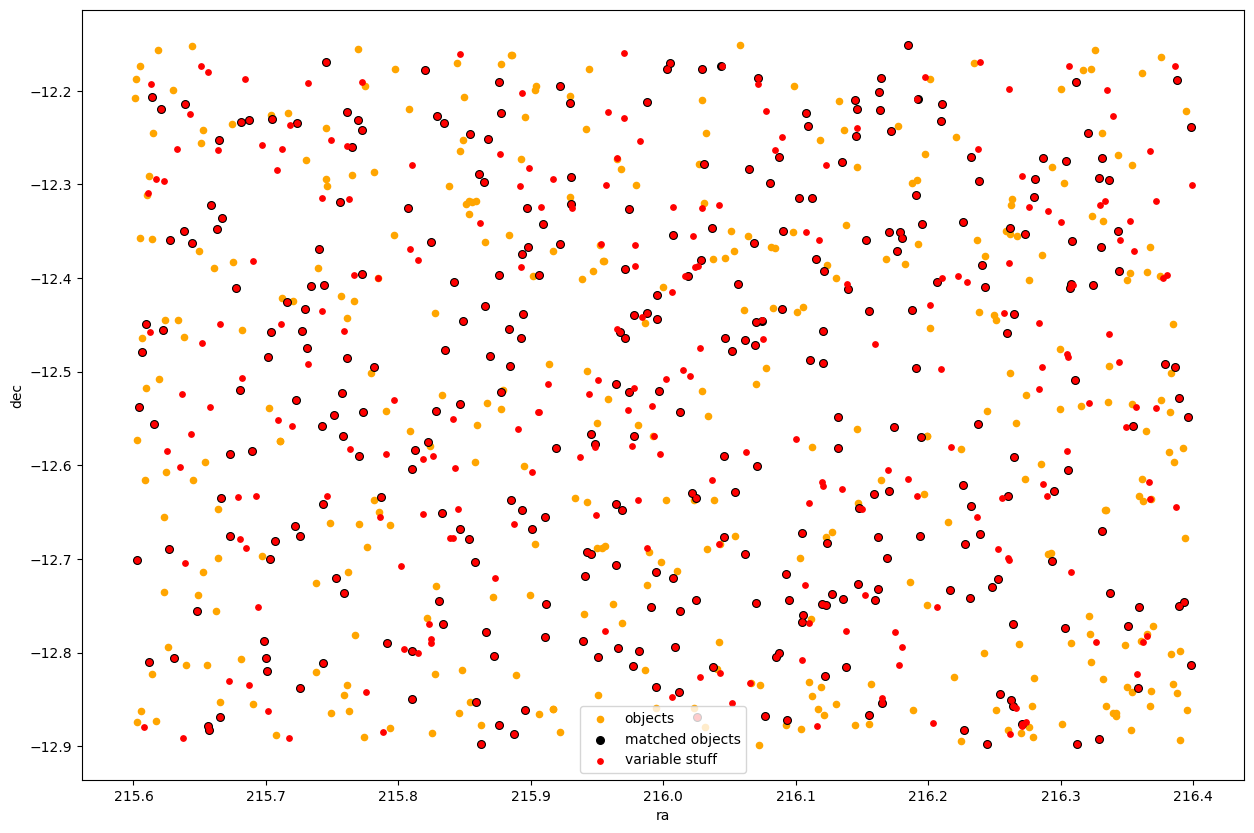

In [74]:
# show the subselection we made 
match_value = 1
# all of the diaObjects in a field
dia_obj_SC = SkyCoord(ra=obj4_field_best_case['ra'].values*u.degree, dec=obj4_field_best_case['dec'].values*u.degree) 
# all of the variable objects in a field
tru_obj_SC = SkyCoord(ra=tru_var_obj_bright['ra'].values*u.degree, dec=tru_var_obj_bright['dec'].values*u.degree)
# match the observations to the truth
idx, d2d, d3d = tru_obj_SC.match_to_catalog_sky(dia_obj_SC)
# index of all diaObj that are within match_value of a true variable object
idx_close = idx[d2d.to(u.arcsec).value<match_value]

# all of diaObjects thare are within match_value of a variable object
matches_close = obj4_field_best_case.iloc[idx_close]


plt.figure(figsize=(15,10))


plt.scatter(obj4_field_best_case['ra'],obj4_field_best_case['dec'], s=20, color = 'orange', label = 'objects')
plt.scatter(matches_close['ra'],matches_close['dec'], s=30, color = 'black', label = 'matched objects')
plt.scatter(tru_var_obj_bright['ra'],tru_var_obj_bright['dec'], color = 'red', label = 'variable stuff', s=15)
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()

In [ ]:
# templates are done from the early data; 

In [ ]:
# raErr, decErr - Nan, where it is coming from, traceback 
# always positive and negative., background subraction failure, are we persisting enough 
# look at the difference images, are background subtractions good enough, 